Using cpu device


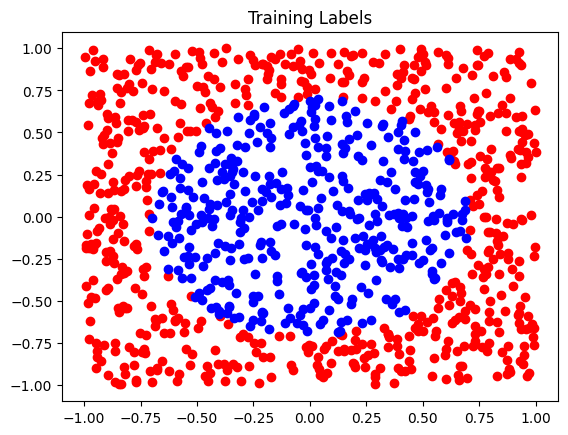

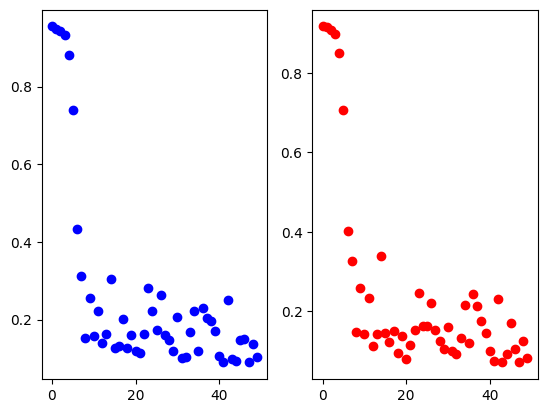

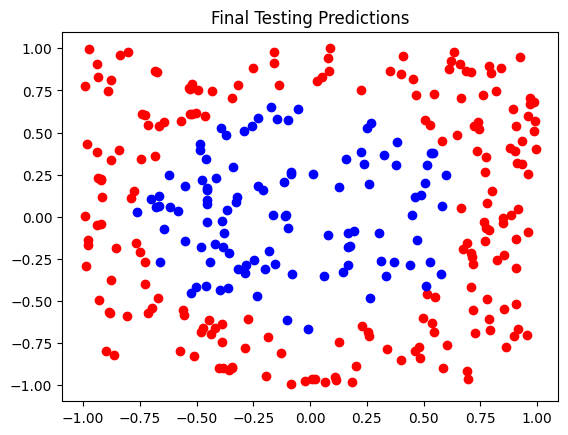

In [93]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    TRAINING_INPUT_N = 1000
    TESTING_INPUT_N = 300
    RNG = np.random.default_rng()
    EPOCH_LIMIT = 50

    def __init__(self):
        super().__init__()
        self.training_inputs = self.generate_inputs(self.TRAINING_INPUT_N)
        self.training_outputs = self.generate_outputs(self.training_inputs)

        self.testing_inputs = self.generate_inputs(self.TESTING_INPUT_N)
        self.testing_outputs = self.generate_outputs(self.testing_inputs)    

        self.layers = nn.Sequential(
            nn.Linear(2, 6), #Bias default to true, they don't count towards the count
            nn.Tanh(),
            nn.Linear(6, 2),
            nn.Tanh(),
            nn.Linear(2, 1),
            nn.Tanh()
        )
        self.loss_function = nn.MSELoss()
        self.learning_rate = 0.01 

        self.e_ins = np.empty(self.EPOCH_LIMIT)
        self.e_outs = np.empty(self.EPOCH_LIMIT)

    def display_labels(self, title, inputs, outputs):
        plt.title(title)
        negative_output_ids = np.nonzero(outputs < 0)
        positive_output_ids = np.nonzero(outputs > 0)

        negative_inputs = inputs[negative_output_ids] 
        xs = negative_inputs[:,0,0]
        ys = negative_inputs[:,0,1]
        plt.scatter(xs, ys, c='red')

        positive_inputs = inputs[positive_output_ids]
        xs = positive_inputs[:,0,0]
        ys = positive_inputs[:,0,1]

        plt.scatter(xs, ys, c='blue')

        plt.show()

    def generate_inputs(self, N):
        return torch.from_numpy(self.RNG.uniform(-1,1,(N, 2))).to(torch.float32)

    def generate_outputs(self, inputs):
        # Circle function (our target function):
        # If x_1^2 + x_2^2 < .5, then we are inside our circle (return +1) (which has radius of sqrt(.5) =~ .707).  else return -1.
        return torch.sign(.5 - (torch.square(inputs[:,0]) + torch.square(inputs[:,1])))

    def forward(self, x):
        # Get the shape right
        prediction = self.layers(x)
        return prediction

    def train(self):
        optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate)

        losses = []

        training_inputs = self.training_inputs
        training_outputs = self.training_outputs
        for epoch_count in range(self.EPOCH_LIMIT):
            # generate permutations
            input_perm = np.random.permutation(len(training_inputs))

            for training_input_id in input_perm:
                training_input = training_inputs[training_input_id]
                optimizer.zero_grad()

                prediction = self.forward(torch.unsqueeze(training_input, 0))

                training_output = torch.reshape(training_outputs[training_input_id], (1,1))                

                loss = self.loss_function(prediction, training_output)
                
                loss.backward()
                optimizer.step()

            # Report E_in and E_out for the epoch
            avg_e_in = self.test(training_inputs, training_outputs)
            self.e_ins[epoch_count] = avg_e_in
            avg_e_out = self.test(self.testing_inputs, self.testing_outputs)
            self.e_outs[epoch_count] = avg_e_out
    
    def test(self, inputs, outputs):
        total_loss = 0
        for input_id, test_input in enumerate(inputs):
            prediction = self.forward(torch.unsqueeze(test_input, 0))

            test_output = torch.reshape(outputs[input_id], (1,1))
            loss = self.loss_function(prediction, test_output)

            total_loss += loss
        
        return total_loss / len(inputs)


    def display_errs(self):
        figure, axis = plt.subplots(1, 2)
        axis[0].scatter(range(0, self.EPOCH_LIMIT), self.e_ins, c='blue')
        axis[1].scatter(range(0, self.EPOCH_LIMIT), self.e_outs, c='red')
        plt.show()

model = NeuralNetwork().to(device)
model.display_labels('Training Labels', model.training_inputs, model.training_outputs)
model.train()
model.display_errs()
model.display_labels('Final Testing Predictions', model.testing_inputs, model.forward(model.testing_inputs))